# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


### 1) Load the CSV & Preview


In [52]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

In [40]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251110.csv'
df = pd.read_csv(path)


### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

In [41]:
# cleaning our data
df_cleaned = df.dropna(subset=['SCORE', 'CRITICAL FLAG', 'BORO', 'CUISINE DESCRIPTION'])
df_cleaned = df[['SCORE', 'CRITICAL FLAG', 'BORO', 'CUISINE DESCRIPTION']]

df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].astype(str)
df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].str.strip().str.lower()

crit_num = []
for x in df_cleaned['CRITICAL FLAG']:
    if x == "critical":
        crit_num.append(1)
    elif x == "not applicable":
        crit_num.append(0)
    else:
        crit_num.append(0)
    
df_cleaned['CRITICAL_NUM'] = crit_num



/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_58979/2706395517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].astype(str)
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_58979/2706395517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].str.strip().str.lower()
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_58979/2706395517.py:17: SettingWithCopyWarnin

### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


In [42]:
# for CUISINE DESCRIPTION categories, I will take top 5 most frequent and make all others "other"

# top 5 + bottom rest
top5_cuisines = df_cleaned['CUISINE DESCRIPTION'].value_counts(ascending=False).head().index.tolist()
the_rest = ~(df_cleaned['CUISINE DESCRIPTION'].isin(top5_cuisines))

# Replacing with Other if not in top5_cuisines
df_cleaned['CUISINE DESCRIPTION'].loc[the_rest] = 'Other'
df_cleaned['CUISINE DESCRIPTION'].value_counts()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_58979/3744077744.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cleaned['CUISINE DESCRIPTION'].loc[the_rest] = 'Other'
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipyker

CUISINE DESCRIPTION
Other             166945
American           45391
Chinese            28426
Coffee/Tea         20230
Pizza              17372
Latin American     13341
Name: count, dtype: int64

In [43]:
df_cleaned = df_cleaned.dropna()

In [44]:
# Our variables

y = df_cleaned['CRITICAL_NUM']
X = sm.add_constant(df_cleaned[['SCORE', 'BORO', 'CUISINE DESCRIPTION']])

In [66]:
y.value_counts()

CRITICAL_NUM
1    154160
0    121135
Name: count, dtype: int64

In [68]:
X['CUISINE DESCRIPTION'].value_counts()

CUISINE DESCRIPTION
Other             155817
American           43668
Chinese            27694
Coffee/Tea         18878
Pizza              16543
Latin American     12695
Name: count, dtype: int64

### 4) Train–Test Split (Stratified)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=y, random_state=30)

### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [47]:
# Pipeline

num_features = ['SCORE']
cat_features = ['BORO', 'CUISINE DESCRIPTION']

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pre = ColumnTransformer(
    transformers= [
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features)
    ])

pipe = Pipeline([
    ('pre', pre),
    ('model', LogisticRegression())
])

In [48]:
model = pipe.fit(x_train, y_train)
y_pred = model.predict(x_test)

### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


AUC-ROC Score: 0.6025


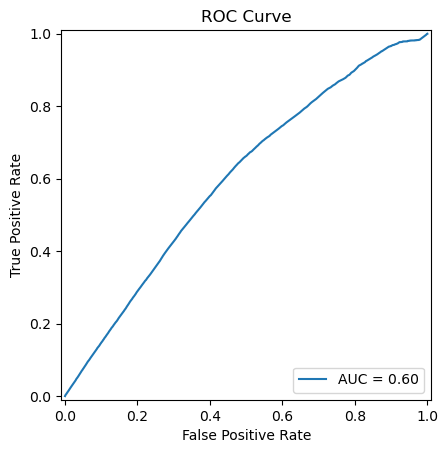

In [69]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# proba's
y_pred_probs = model.predict_proba(x_test)[:, 1]
# this is for the positive class

# plot auc-roc curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC Score: {roc_auc:.4f}")

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('ROC Curve')
plt.show()

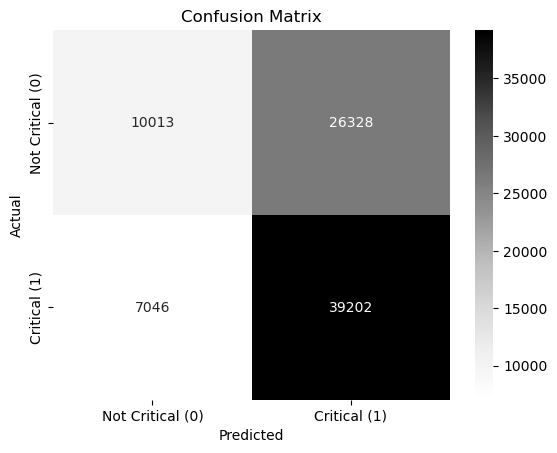

                  precision    recall  f1-score   support

Not Critical (0)       0.59      0.28      0.38     36341
    Critical (1)       0.60      0.85      0.70     46248

        accuracy                           0.60     82589
       macro avg       0.59      0.56      0.54     82589
    weighted avg       0.59      0.60      0.56     82589



In [64]:
# confusion matrix 3
cm = confusion_matrix(y_test, y_pred)

# visualizing with heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=['Not Critical (0)', 'Critical (1)'],
            yticklabels=['Not Critical (0)', 'Critical (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# report
print(classification_report(y_test, y_pred, target_names=['Not Critical (0)', 'Critical (1)']))



### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.


In [70]:
# Adjusting Threshold

thresh = 0.50
# setting a lower threshold to catch more true positives-- at the risk of catching more false positives

thresh_preds = (y_pred_probs >= thresh).astype(int)

print(classification_report(y_test, thresh_preds, target_names=['Not Critical (0)', 'Critical (1)']))

                  precision    recall  f1-score   support

Not Critical (0)       0.59      0.28      0.38     36341
    Critical (1)       0.60      0.85      0.70     46248

        accuracy                           0.60     82589
       macro avg       0.59      0.56      0.54     82589
    weighted avg       0.59      0.60      0.56     82589



## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom).  
2) **Stakeholder one-liner:** In plain English: “Using **[features…]**, our model at threshold **T** yields **[metric values]**. This means **[business implication about false alarms vs misses]**. Next, we’d **[tune threshold, add features, address imbalance, etc.]**.”

> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.


Given the relatively balanced dataset, I chose to observe the ROC curve. This will also help me differentiate the differences between the two classifications, 0 or 1. However, the results of the AUC-ROC score and the plotted ROC curve indicate to us that the classification of the model is near random, with a score of ~0.60.

Given this:
Using health inspection scores, boroughs, and top 5 cuisine types, our model with a threshold of 0.5 yields average precision and drastically contrasting recall scores. Overall, the f-scores are relatively poor and indicate that the model could use improvement with different features. This means that, even with our threshold lowered to catch more critical flags, The model will still miss a decent amount of critical restaurants. Furthermore, the low recall for non-critical restaurants could indicate that the model is not finding the non-critical restaurants well.